In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [3]:
#!/usr/bin/python
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.signal as scsig
import spectrum as sp
import signale
import cPickle as pkl
import time
import statsmodels.api as sm
import signale.tools as tools
import sys,os
import trajectory
from sklearn.cluster import KMeans
from matplotlib.mlab import specgram
import matplotlib.mlab as mlab

###Functions
def MA(array,ord=2):
    ma = np.array([array[ii-ord/2:ii+ord/2].mean() for ii in range(array.size) if ii >= ord ],dtype=float)
    ma = np.insert(ma,0,array[0:ord/2])
    ma = np.append(ma,array[-(ord/2)-1:-1])
    return ma
def zScore(array):
    return(array - np.average(array))/ np.std(array)
def nvt_loader(filename):
    """ 
    Memory map the Neuralynx .nvt format
    Fields
    -------
    swstx
    swid
    sw_data_size
    qTimeStamps       Cheetah timestamp for this record. This value is in microseconds.
    dwpoints          Points with the color bitfield values for this record.This is a 400
                      element array.  See Video Tracker in reference. 
    sncrc
    dnextracted_x     Extracted X location of the target being tracked. 
    dnextracted_y     Extracted Y location of the target being tracked.
    dnextracted_angle The calculated head angle in degrees clockwise from the positive Y
                      axis. Zero will be assigned if angle tracking is disabled.
    dnTargets         Colored targets using the samebitfield format used by the dwPoints array.
                      Instead of transitions, the bitfield indicates the colors that make up 
                      each particular target and the center point of that target.  This is a 50
                      element array sorted by size from largest (index 0) to smallest(index 49).
                      A target value of 0 means that no target is present in thatindex location.
                      See Video Tracker Bitfield Information in reference. 
    
    Reference:
    ----------
        http://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """ 
    nev_dtype = np.dtype([
        ('swstx'              , '<i2'),
        ('swid'               , '<i2'),
        ('sw_data_size'       , '<i2'),
        ('qTimeStamps'        , '<u8'),
        ('dwPoints'           , '<u4',(400,)),
        ('sncrc'              , '<i2'),
        ('dnextracted_x'      , '<i4'),
        ('dnextracted_y'      , '<i4'),
        ('dnextracted_angle'  , '<i4'),
        ('dnTargets'          , '<i4',(50,)),
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='readwrite',
       offset=(16 * 2**10))

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
animalPath = '/home/chenani/dataWork/ali/MECLesion_SleepData/Magda/Rat405Lesion/'
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat405Lesion/dataFiles/sleepDB/'
nvtPaths = []
for nvt in tools.locate('*.nvt',animalPath):
    nvtPaths.append(os.path.join(nvt[0],nvt[1]))
nvtPaths = sorted(nvtPaths)
nvtPaths = np.array(nvtPaths)
print [item for item in nvtPaths]

['/home/chenani/dataWork/ali/MECLesion_SleepData/Magda/Rat405Lesion/LinearTrack_0-0-0_Day1/01-sleep1/VT1.nvt', '/home/chenani/dataWork/ali/MECLesion_SleepData/Magda/Rat405Lesion/LinearTrack_0-0-0_Day1/02-lineartrack1/VT1.nvt', '/home/chenani/dataWork/ali/MECLesion_SleepData/Magda/Rat405Lesion/LinearTrack_0-0-0_Day1/03-sleep2/VT1.nvt']


/home/chenani/dataWork/ali/MECLesion_SleepData/Magda/Rat405Lesion/LinearTrack_0-0-0_Day1/01-sleep1/VT1.nvt
/home/chenani/dataWork/ali/MECLesion_SleepData/Magda/Rat405Lesion/LinearTrack_0-0-0_Day1/03-sleep2/VT1.nvt


/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in less
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in greater
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in greater


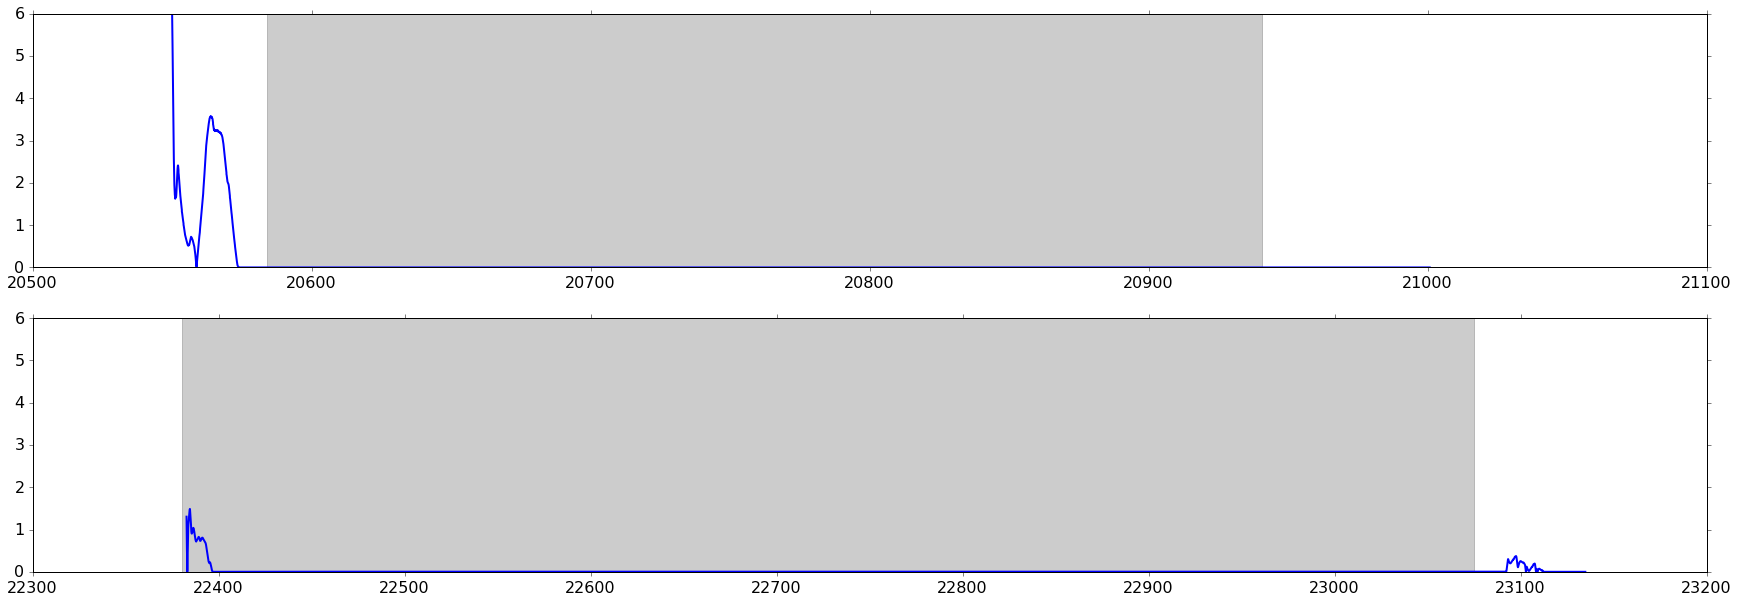

In [5]:
f,ax = pl.subplots(2,1,figsize=[30,10])
for iii,nvtFile in enumerate(nvtPaths[[0,2]]):
    immoDB = pd.DataFrame([],columns=['t_start','t_stop','type'])
    pathSplit = nvtFile.split('/')
    datecnd = np.array(['LinearTrack' in item for item in pathSplit])
    sessioncnd = np.array(['-sleep' in item for item in pathSplit])
    animalcnd = np.array(['Rat' in item for item in pathSplit])
    date =  np.array(pathSplit)[datecnd][0].split('_')[-1]
    animal =  np.array(pathSplit)[animalcnd][0].split('_')[-1]
    ####Loading trajectory data
    print nvtFile
    ts = np.array(nvt_loader(nvtFile)['qTimeStamps']/1e6)
    x  = np.array(nvt_loader(nvtFile)['dnextracted_x'])
    y  = np.array(nvt_loader(nvtFile)['dnextracted_y'])
    a  = np.array(nvt_loader(nvtFile)['dnextracted_angle'])
    r = np.sqrt(np.power(x,2)+np.power(y,2))
    #### Fixing invalid position data points
    dta = pd.DataFrame(np.transpose([ts,x,y,a,r]),columns=['t','x','y','a','r'])
    dta = dta.replace(0,np.nan)
    ###Determining the moving average of position and head direction
    dtaI = dta.interpolate()
    xRange = dtaI.x.max()- dtaI.x.min()
    yRange = dtaI.y.max()- dtaI.y.min()
    littleFactor = 30.48/min(xRange,yRange)
    biggerFactor = 55.88/max(xRange,yRange)
    if xRange<yRange:
        dtaI.x*=littleFactor
        dtaI.y*=biggerFactor
    else:
        dtaI.x*=biggerFactor
        dtaI.y*=littleFactor
    dtaI.x = MA(dtaI.x,300)
    dtaI.y = MA(dtaI.y,300)
    dtaI.y = MA(dtaI.a,300)
    dtaI.r = np.sqrt(np.power(dtaI.x,2)+np.power(dtaI.y,2))
    Vx = MA(np.diff(dtaI.x)/np.diff(dtaI.t),160)
    Vy = MA(np.diff(dtaI.y)/np.diff(dtaI.t),160)
    Speed = np.sqrt(np.square(Vx),np.square(Vy))
    cond1 = Speed < 2.
    chIdx = np.where(pd.rolling_std(cond1,2)>0)[0]
    if not chIdx.size:
        immoDB = immoDB.append(pd.DataFrame([[dtaI.t[0]+60,dtaI.t[dtaI.shape[0]-1]-60,'asleep']],columns=['t_start','t_stop','type']),ignore_index=True)
        if not iii:
            immoDB.to_pickle(dataFolder+'ImmPeriods-'+animal+'-'+date+'-01-pre.db')
        else:
            immoDB.to_pickle(dataFolder+'ImmPeriods-'+animal+'-'+date+'-03-post.db')
        ax[iii].plot(dtaI.t[:-1],Speed)
        for idx,row in immoDB[immoDB.type=='asleep'].iterrows():
            ax[iii].axvspan(row.t_start,row.t_stop,color='k',alpha=0.2)
        ax[iii].set_ylim([0,6])  
        continue;
    kk = 0
    while kk <chIdx.size:
        initIdx =  chIdx[kk-1]
        finIdx =   chIdx[kk]
        if finIdx - initIdx < 10 and finIdx-initIdx > 0:
            cond1[initIdx:finIdx] = np.ones(finIdx-initIdx)
        kk+=2
    ####Extracting long spans of immobility!
    sleepList = []
    chIdx = np.where(pd.rolling_std(cond1,2)>0)[0]
    if cond1[chIdx[0]-1]:
        if chIdx[0] > 150:
            sleepList.append(ts[0],ts[chIdx[0]])
            kk = 1
    else:
        kk = 0
    while kk < len(chIdx)-1:
        try:
            if  chIdx[kk+1] - chIdx[kk]> 150:
                sleepList.append([ts[chIdx[kk]],ts[chIdx[kk+1]]])
            kk+=2 
        except ValueError:
            print kk
            kk +=2
    sleepList = np.array(sleepList)
    slFlat = sleepList.flatten()
    duDi = np.diff(slFlat)
    for DiIdx in np.where(duDi<2)[0]:
        slFlat[DiIdx] -= slFlat[DiIdx]
        slFlat[DiIdx+1] -= slFlat[DiIdx+1]
    sleepListFixed = slFlat[slFlat>0].reshape([slFlat[slFlat>0].shape[0]/2,2])
    slst = []
    for ii in range(sleepListFixed.shape[0]):
        if sleepListFixed[ii,1]-sleepListFixed[ii,0]>60:
            slst.append([sleepListFixed[ii,0],sleepListFixed[ii,1]])
    if len(slst):
        for ii,item in enumerate(slst):
            immoDB = immoDB.append(pd.DataFrame([[item[0],item[1],'asleep']],columns=['t_start','t_stop','type']),ignore_index=True)
            try:
                immoDB = immoDB.append(pd.DataFrame([[item[1],slst[ii+1][0],'awake']],columns=['t_start','t_stop','type']),ignore_index=True)
            except IndexError:
                print 'Done with %s' %nvtFile
    else:
        immoDB = immoDB.append(pd.DataFrame([[dtaI.t[0]+60,dtaI.t[dtaI.shape[0]-1]-60,'asleep']],columns=['t_start','t_stop','type']),ignore_index=True)
    
    if not iii:
        immoDB.to_pickle(dataFolder+'ImmPeriods-'+animal+'-'+date+'-01-pre.db')
    else:
        immoDB.to_pickle(dataFolder+'ImmPeriods-'+animal+'-'+date+'-03-post.db')
    ax[iii].plot(dtaI.t[:-1],Speed)
    for idx,row in immoDB[immoDB.type=='asleep'].iterrows():
        ax[iii].axvspan(row.t_start,row.t_stop,color='k',alpha=0.2)
    ax[iii].set_ylim([0,6])        

In [6]:
immoDB


,t_start,t_stop,type
0,22380.244506,23074.888723,asleep


In [10]:
pd.read_pickle(dataFolder+'ImmPeriods-Rat3839-Day5-03-post.db')

,t_start,t_stop,type
0,3660.64,5345.960459,asleep


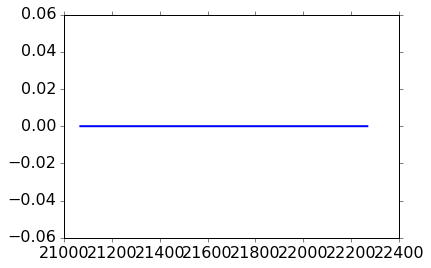

In [41]:
pl.plot(ts,r)